<a href="https://colab.research.google.com/github/MarinaChau/AttaCoeurs/blob/main/Attack_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('myDrive')

Mounted at myDrive


In [2]:
!git clone https://github.com/MarinaChau/AttaCoeurs.git

Cloning into 'AttaCoeurs'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


# Project Adversarial Attack

In [3]:
%cd AttaCoeurs

/content/AttaCoeurs


In [4]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from AttaCoeurs.src import adversarial_attacks as attacks
from AttaCoeurs.src import custom_model as models



### 1.1 Code `∞-PGD attack & Observe robustness of neural networks


### STEP 1: Load Cifar10 Dataset

In [5]:
# Load Cifar dataset from keras
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(50000,32, 32,3).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 32, 32, 3).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### STEP 2 Build a simpler Classifier

In [86]:
# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [32, 32, 3]
        self.num_classes = 10
        self.num_conv_filters = [64, 64, 32, 32]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [512]
        
cnn_params = CnnParams()


def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    #x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    
    # Convolutional layer followed by 
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, cnn_params.kernel_size, padding='same', activation='relu')(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # max pooling between convolutional layers + dropout
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size)(x)
            x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)

    for num_units in cnn_params.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                              adv_training_with=adv_training_with)



def build_model(batch_size, num_classes, epochs, learning_rate=0.0001, decay=1e-06):

    inputs = tf.keras.Input(shape=x_train.shape[1:])
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifar_classifier")
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
            loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()

    return model

In [87]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = [tf.keras.metrics.SparseCategoricalAccuracy]
OPTIMIZER = tf.keras.optimizers.RMSprop()

In [88]:
model = get_cnn_model()
model.summary()

Model: "custom_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                               

In [89]:
# Compile Model
model.compile(optimizer=OPTIMIZER,
              loss=LOSS, metrics=["accuracy"])
# Train Model 
history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=40, validation_split=0.2)

# Evaluate Model
print("\n")
evaluation = model.evaluate(x_test,y_test, verbose=2)

Epoch 1/40
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6938 - accuracy: 0.3774 - val_loss: 1.4934 - val_accuracy: 0.4481
Epoch 2/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3454 - accuracy: 0.5150 - val_loss: 1.1544 - val_accuracy: 0.5949
Epoch 3/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2121 - accuracy: 0.5661 - val_loss: 1.0579 - val_accuracy: 0.6313
Epoch 4/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1401 - accuracy: 0.5985 - val_loss: 1.0636 - val_accuracy: 0.6216
Epoch 5/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0899 - accuracy: 0.6177 - val_loss: 0.9903 - val_accuracy: 0.6631
Epoch 6/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0650 - accuracy: 0.6314 - val_loss: 0.9430 - val_accuracy: 0.6601
Epoch 7/40
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0460 - accuracy: 0.6378 - val_loss: 0.9589 - val_accuracy:

In [90]:
evaluation = model.evaluate(x_test,y_test, verbose=2)

313/313 - 1s - loss: 0.9833 - accuracy: 0.6694 - 751ms/epoch - 2ms/step


### STEP 3 PGD L-Inf on our model

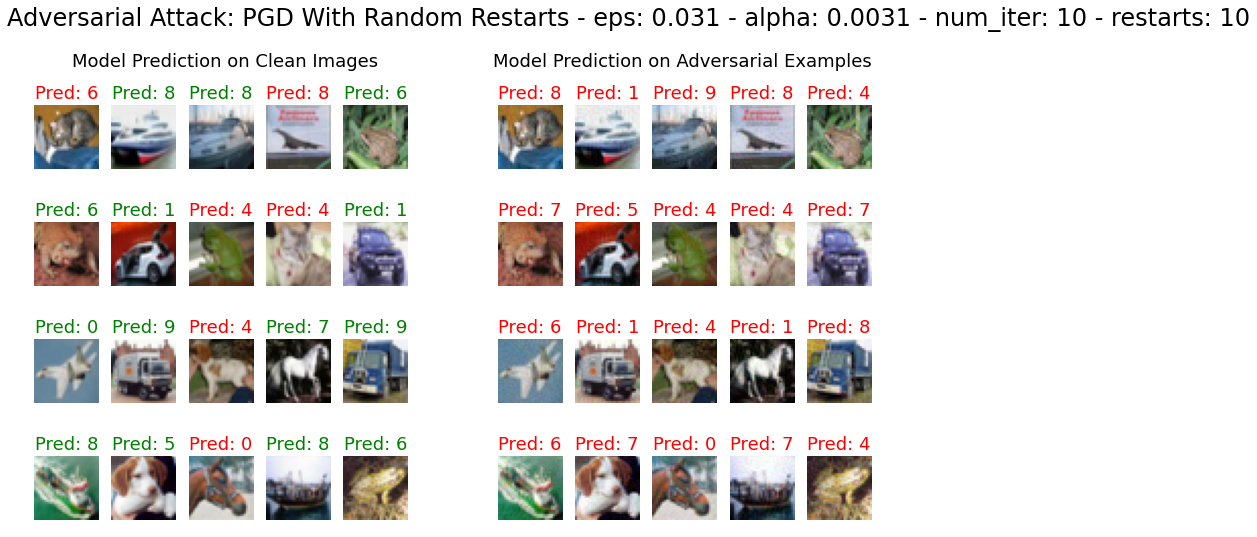

In [109]:
# Attack to be tested
Attack = attacks.PgdRandomRestart
# Attack parameters
eps = 0.031
num_iter = 10
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}


attacks.attack_visual_demo(model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

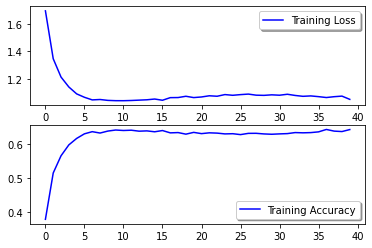

In [106]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [103]:
!pwd

/content/AttaCoeurs


In [108]:
# save model
import os
# model_save_path = "/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5"
model_save_path = "../model.h5"
print(os.path.exists(model_save_path))
model.save(model_save_path)

True


#### Load the module



In [64]:
import os
print(os.path.exists("/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5"))
model = tf.keras.models.load_model("/myDrive/MyDrive/Projet DL/model_CIFAR10_v2.h5")

True


### b. Code PGD and test it on the network

In [ ]:
# Exercise: Implement the BIM attack seen in class
import numpy as np


def fgsm(x_numpy, y_numpy, epsilon, model=model):
  x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32)
  y = tf.constant(tf.one_hot(y_numpy, 10))
  with tf.GradientTape() as g: 
    g.watch(x)
    #### YOUR CODE HERE
    p = model(x)
    loss = tf.keras.backend.categorical_crossentropy(target=y, output=tf.reshape(p, -1))
    dloss_dx = g.gradient(loss, x)
    gradient = np.sign(dloss_dx)
    x_attack = x + epsilon * gradient
    x_attack = np.reshape(x_attack, (28, 28))
    x_attack = np.clip(np.floor(x_attack), 0, 255)
    ####
  return x_attack

  
def linf_PGD(x, y, epsilon, num_iter, model=model):

  epsilon_iter = 10 * epsilon / num_iter

  x_attack = tf.convert_to_tensor(x)
  for _ in range(num_iter):
    with tf.GradientTape() as g: 
      g.watch(x_attack)
      p = model(x_attack)
      loss = tf.keras.backend.categorical_crossentropy(y, p)
      dloss_dx = g.gradient(loss, x_attack)
      gradient = np.sign(dloss_dx)
      x_attack = x_attack + epsilon_iter*gradient
      eta = tf.clip_by_value(x_attack - x, -epsilon, epsilon)
      x_attack = tf.clip_by_value(x+eta, 0, 255)

  return x_attack


In [ ]:
x_attack = linf_PGD(x_test[:10], y_test[:10], epsilon=0.002, num_iter=10)



NameError: ignored

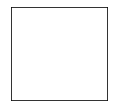

In [113]:
# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (10):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_attack[i], cmap=plt.cm.binary)
  #plt.xlabel(class_names[train_labels[i][0]])

plt.show()

#### Evaluate the model on Cifar10 with different epsilon values

In [115]:
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}
x_test_adv = Attack(x_test, y_test, attack_kwargs)

TypeError: ignored

In [ ]:
list_attack_n = []
for i in range(1, 10, 2):
    print(f"iteration number {i}")
    x_attack_a = linf_PGD(x_test[:], y_test[:], epsilon=0.002, num_iter=i)
    x_attack_b = linf_PGD(x_test[:], y_test[:], epsilon=0.005, num_iter=i)
    x_attack_c = linf_PGD(x_test[:], y_test[:], epsilon=0.02, num_iter=i)
    x_attack_d = linf_PGD(x_test[:], y_test[:], epsilon=0.05, num_iter=i)
    list_attack_n.append([x_attack_a, x_attack_b, x_attack_c, x_attack_d])


iteration number 1
iteration number 3
iteration number 5
iteration number 7
iteration number 9


In [ ]:
list_attack_n[1][0]

<tf.Tensor: shape=(10000, 32, 32, 3), dtype=float64, numpy=
array([[[[0.62160784, 0.44121569, 0.19015686],
         [0.62552941, 0.43729412, 0.18631373],
         [0.64905882, 0.45690196, 0.202     ],
         ...,
         [0.5352549 , 0.37454902, 0.13917647],
         [0.49211765, 0.35486275, 0.14317647],
         [0.45690196, 0.33533333, 0.12741176]],

        [[0.59407843, 0.43721569, 0.198     ],
         [0.59015686, 0.43337255, 0.15886275],
         [0.62152941, 0.44905882, 0.17447059],
         ...,
         [0.53533333, 0.37454902, 0.12356863],
         [0.48819608, 0.35486275, 0.1234902 ],
         [0.46866667, 0.34709804, 0.13533333]],

        [[0.59015686, 0.42937255, 0.18231373],
         [0.59015686, 0.42945098, 0.12741176],
         [0.61760784, 0.43729412, 0.14317647],
         ...,
         [0.54709804, 0.38631373, 0.13533333],
         [0.50780392, 0.37054902, 0.13533333],
         [0.47258824, 0.34701961, 0.12741176]],

        ...,

        [[0.26866667, 0.48427451

In [ ]:
def get_results_adv(list_of_attacks, model, labels):
    results = {}
    for i in range(len(list_attack_n)):
        results[i] = []
        for j in range(len(list_attack_n[i])):
            results[i].append(model.evaluate(list_attack_n[i][j], labels))

    return results


In [ ]:
res = get_results_adv(list_attack_n, model, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 24.7789 - acc: 0.0042


In [ ]:
res

{0: [[1.1007287502288818, 0.6430000066757202],
  [1.8743789196014404, 0.47450000047683716],
  [4.398003101348877, 0.1551000028848648],
  [5.443645477294922, 0.08139999955892563]],
 1: [[1.121931791305542, 0.6313999891281128],
  [2.042156934738159, 0.4422999918460846],
  [6.318862438201904, 0.1446000039577484],
  [9.806933403015137, 0.04450000077486038]],
 2: [[1.1208252906799316, 0.6313999891281128],
  [2.0296998023986816, 0.44130000472068787],
  [6.587560176849365, 0.1420000046491623],
  [10.342347145080566, 0.045499999076128006]],
 3: [[1.1335787773132324, 0.6280999779701233],
  [2.179654598236084, 0.4203000068664551],
  [8.913883209228516, 0.10329999774694443],
  [18.125051498413086, 0.013000000268220901]],
 4: [[1.1402690410614014, 0.6254000067710876],
  [2.2658848762512207, 0.4083000123500824],
  [10.729294776916504, 0.0729999989271164],
  [24.78097915649414, 0.00419999985024333]]}

In [ ]:
iter_1 = [res[i][0][1] for i in range(5)]
iter_2 = [res[i][1][1] for i in range(5)]
iter_3 = [res[i][2][1] for i in range(5)]
iter_4 = [res[i][3][1] for i in range(5)]


Text(0, 0.5, 'Accuracy %')

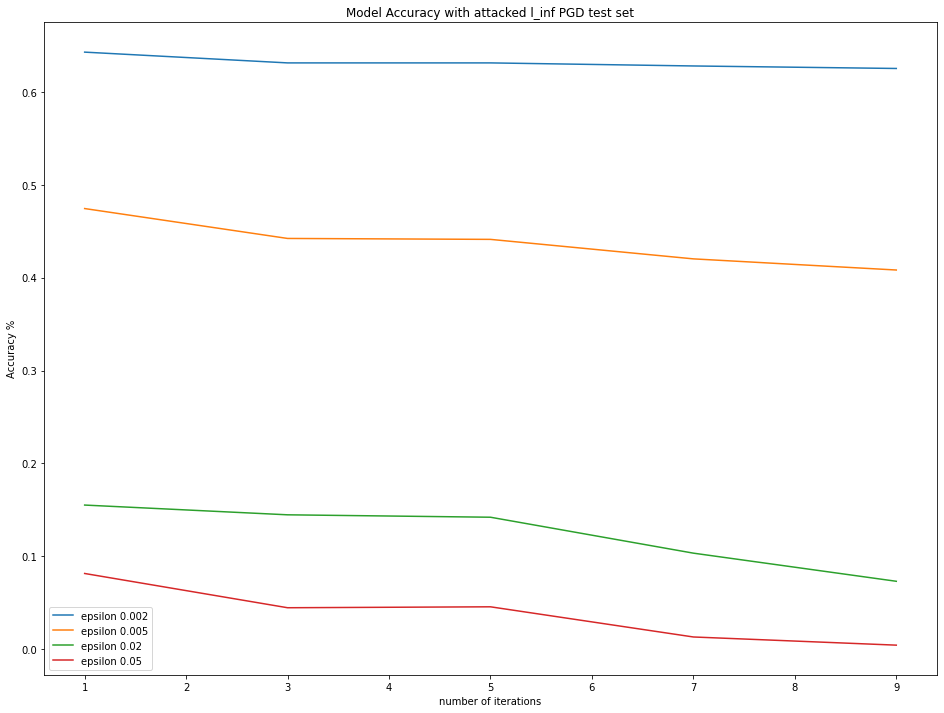

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(np.arange(1,10, 2), iter_1, label="epsilon 0.002")
plt.plot(np.arange(1,10, 2), iter_2, label="epsilon 0.005")
plt.plot(np.arange(1,10, 2), iter_3, label="epsilon 0.02")
plt.plot(np.arange(1,10, 2), iter_4, label="epsilon 0.05")
plt.legend()
plt.title("Model Accuracy with attacked l_inf PGD test set")
plt.xlabel("number of iterations")
plt.ylabel("Accuracy %")

### 1.2 Code Adversarial training & Observe robustness of neural networks

In [ ]:
# Marina CHAU - Modifier la classe mais sinon PGD avec Random Start comme dans le papier de %adry

def linf_PGD(x, y, epsilon, num_iter, model=model):

  epsilon_iter = 10 * epsilon / num_iter

  x_attack = tf.convert_to_tensor(x)
  for _ in range(num_iter):
    with tf.GradientTape() as g: 
      g.watch(x_attack)
      p = model(x_attack)
      loss = tf.keras.backend.categorical_crossentropy(y, p)
      dloss_dx = g.gradient(loss, x_attack)
      gradient = np.sign(dloss_dx)
      x_attack = x_attack + epsilon_iter*gradient
      eta = tf.clip_by_value(x_attack - x, -epsilon, epsilon)
      x_attack = tf.clip_by_value(x+eta, 0, 255)

  return x_attack


class AdversarialAttack:

    def __init__(self, model, eps):
        """
        A class to create an Attack
        Parameters:

            model: tf.keras.Model - model that is used to generate adversarial examples with attack
            eps: np.float - max perturbation size of adversarial attack
        """
        self.model = model
        self.eps = eps
        self.name = None
    
    class LinfPgd(AdversarialAttack):
        """
        PGD attack class
        """

        super().__init__(model, eps)
        self.name = "PGD"
        self.alpha = alpha
        self.num_iter = num_iter
        self.restarts = restarts

    def __call__(self, clean_images, true_labels):
        """
        
        """
        # Get loss on clean_images
        max_loss = tf.keras.losses.SparseCategoricalCrossentropy(
            reduction=tf.keras.losses.Reduction.NONE)(true_labels, self.model(clean_images))
        # max_X contains adversarial examples and is updated after each restart
        max_X = clean_images[:, :, :, :]
""
        # Start restart loop
        for i in tf.range(self.restarts):
            # Get random perturbation uniformly in l infinity epsilon ball
            random_delta = 2 * self.eps * tf.random.uniform(shape=clean_images.shape) - self.eps
            # Add random perturbation
            X = clean_images + random_delta

            # Start projective gradient descent from X
            for j in tf.range(self.num_iter):
                # Track gradients
                with tf.GradientTape(watch_accessed_variables=False) as tape:
                    # Only gradients w.r.t. X are taken NOT model parameters
                    tape.watch(X)
                    pred = self.model(X)
                    loss = self.loss_obj(true_labels, pred)

                # Get gradients of loss w.r.t X
                gradients = tape.gradient(loss, X)
                # Compute perturbation as step size times sign of gradients
                perturbation = self.alpha * tf.sign(gradients)
                # Update X by adding perturbation
                X = X + perturbation
                # Make sure X did not leave L infinity epsilon ball around clean_images
                X = tf.clip_by_value(X, clean_images - self.eps, clean_images + self.eps)
                # Make sure X has entries between 0 and 1
                X = tf.clip_by_value(X, 0, 1)

            # Get crossentroby loss for each image in X
            loss_vector = tf.keras.losses.SparseCategoricalCrossentropy(
                reduction=tf.keras.losses.Reduction.NONE)(true_labels, self.model(X))

            # mask is 1D tensor where true values are the rows of images that have higher loss than previous restarts
            mask = tf.greater(loss_vector, max_loss)
            # Update max_loss
            max_loss = tf.where(mask, loss_vector, max_loss)
            """
            we cannot do max_X[mask] = X[mask] like in numpy. We need mask that fits shape of max_X.
            Keep in mind that we want to select the rows that are True in the 1D tensor mask.
            We can simply stack the mask along the dimensions of max_X to select each desired row later.
            """
            # Create 2D mask of shape (max_X.shape[0],max_X.shape[1])
            multi_mask = tf.stack(max_X.shape[1] * [mask], axis=-1)
            # Create 3D mask of shape (max_X.shape[0],max_X.shape[1], max_X.shape[2])
            multi_mask = tf.stack(max_X.shape[2] * [multi_mask], axis=-1)
            # Create 4D mask of shape (max_X.shape[0],max_X.shape[1], max_X.shape[2], max_X.shape[3])
            multi_mask = tf.stack(max_X.shape[3] * [multi_mask], axis=-1)

            # Replace adversarial examples max_X[i] that have smaller loss than X[i] with X[i]
            max_X = tf.where(multi_mask, X, max_X)

        # return adversarial examples
        return max_X





    

IndentationError: ignored

In [ ]:
# Set adversarial training parameters
eps = 0.3
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}
adv_training_with = {"attack": attacks.PgdRandomRestart,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

# Train model
cnn_model_pgd.fit(x_train, y_train,
                   batch_size=32,epochs=2,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_pgd.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_pgd.test_adv_robustness(x_test[:100], y_test[:100]

SyntaxError: ignored

# NEW PART 

In [37]:
!git clone https://github.com/hechenghai/Adversarial_Machine_Learning_Tensorflow.git

Cloning into 'Adversarial_Machine_Learning_Tensorflow'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 190 (delta 93), reused 100 (delta 30), pack-reused 0
Receiving objects: 100% (190/190), 4.33 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [39]:
%cd Adversarial_Machine_Learning_Tensorflow/

/content/Adversarial_Machine_Learning_Tensorflow


In [41]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from adversarial_ml import adversarial_attacks as attacks
from adversarial_ml import custom_model as models

In [45]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [47]:
x_test.shape

(10000, 32, 32, 3)

In [48]:
x_train = tf.constant(x_train.reshape(50000,32, 32, 3).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 32, 32, 3).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [53]:

# Parameters for the architecture of fully connected neural networks
class FcParams(object):
    def __init__(self):
        self.input_shape = [28,28,1]
        self.num_classes = 10
        self.num_fc_units = [64,32,32]

# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [32, 32, 3]
        self.num_classes = 10
        self.num_conv_filters = [32, 64, 64]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        
fc_params = FcParams()
cnn_params = CnnParams()

In [54]:
def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    
    # Convolutional layer followed by 
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, cnn_params.kernel_size, activation='relu')(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # max pooling between convolutional layers
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size)(x)
    
    x = tf.keras.layers.Flatten()(x)

    for num_units in cnn_params.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                              adv_training_with=adv_training_with)

In [55]:
LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = [tf.keras.metrics.SparseCategoricalAccuracy]
OPTIMIZER = tf.keras.optimizers.RMSprop()

In [56]:
cnn_model = get_cnn_model()
cnn_model.summary()

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)      

Epoch 1/20


AssertionError: ignored

AssertionError: ignored

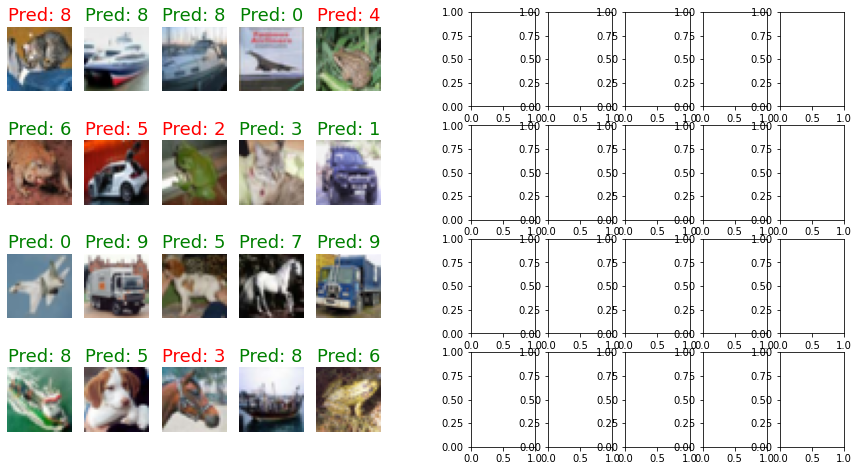

In [64]:
# Attack to be tested
Attack = attacks.PgdRandomRestart
# Attack parameters
attack_kwargs = {"eps": 0.2, "alpha": 1.25*0.2, "num_iter":10, "restarts":False}


attacks.attack_visual_demo(cnn_model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

In [2]:
# Set adversarial training parameters
eps = 0.031 
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter, "restarts": 10}
adv_training_with = {"attack": attacks.PgdRandomRestart,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=OPTIMIZER,
                       loss=LOSS, metrics=["accuracy"])

# Train model
cnn_model_pgd.fit(x_train, y_train,
                   batch_size=32,epochs=10,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_pgd.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_pgd.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

NameError: ignored

*texte en italique*# Nouvelle section